In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
import pickle as pk,numpy as np, warnings
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.gridspec import GridSpec as gs
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd
from adjustText import adjust_text as adt
import warnings

### Load reporter strain data along with their protein features

In [2]:
warnings.filterwarnings('ignore')

pro_features = pk.load(open('./Important_References/union_ortho_table_withFeatures.pk','rb'))
numeric_feature_cols = list(pro_features.columns[25:])+['Msm_PI','Msm_Aliphatic_Index']
numeric_feature_normalized = StandardScaler().fit_transform(pro_features[numeric_feature_cols].values)

#load reporter data
deg_stats = pd.read_excel("./Important_References/Deg_stats_final_pub.xlsx").drop(columns=['Unnamed: 0'])
ref = pd.read_excel('./Important_References/Flow_well_keys_pub.xlsx')

#Remove control strain rows from the deg_stats file
msm_filtered = deg_stats[deg_stats['Substrate']!='No Target'].copy()

# group strains by their deg constant
msm_filtered['Deg_group']=(msm_filtered['log2(Deg constant)'].values>-6)*1

# plate5 as validation set
msm_filtered['as_validation'] = [1 if x in ref[ref['Plate']=='Plate5']['Locus_tag'].unique() else 0 for x in msm_filtered['Locus']]

ortho_normalized = pro_features.copy().drop(columns=numeric_feature_cols)
ortho_normalized[numeric_feature_cols]=numeric_feature_normalized
ortho_normalized['gene'] = ortho_normalized.index

# normalize protein features
msm_filtered[numeric_feature_cols] = ortho_normalized.loc[msm_filtered['Locus'].values,numeric_feature_cols].copy().values

FileNotFoundError: [Errno 2] No such file or directory: './Important_References/union_ortho_table_withFeatures.pk'

In [4]:
#save data
msm_filtered.to_csv('./Important_References/reporter_assay_features_normalized.csv')
ortho_normalized.to_csv('./Important_References/union_ortho_table_withFeaturesNormalized.csv')

In [5]:
pooled_stats = msm_filtered.copy()
train_df = pooled_stats[pooled_stats['as_validation']==0] #data generated before August
validation_df = pooled_stats[pooled_stats['as_validation']==1] #data generated after August

#
print("{} entries found in training set and {} entries found in a independently generated validation dataset.".format(len(train_df),len(validation_df)))
print("A total number of {} normalized features extracted.".format(len(numeric_feature_cols)))

54 entries found in training set and 18 entries found in a independently generated validation dataset.
A total number of 485 normalized features extracted.


[]

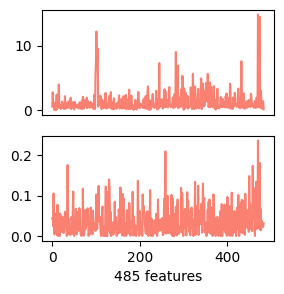

In [6]:
# feature selection
from sklearn.feature_selection import mutual_info_regression, f_regression, SelectKBest

def select_features_corr(X_train, y_train, X_test):
    """
    Adopted from https://machinelearningmastery.com/feature-selection-for-regression-data/
    """
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

def select_features_mutualInfo(X_train, y_train, X_test):
    # configure to select a subset of features
    fs = SelectKBest(score_func=mutual_info_regression, k=88)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

X,y = train_df[numeric_feature_cols].values,train_df['log2(Deg constant)'].values

n_trials=10
score_pad_corr = np.zeros((n_trials,len(numeric_feature_cols)))
score_pad_mi = np.zeros((n_trials,len(numeric_feature_cols)))

for i in range(n_trials):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    X_train_fs_corr, X_test_fs_linear_corr, fs_corr = select_features_corr(X_train,y_train,X_test)
    X_train_fs_mi, X_test_fs_linear_mi, fs_mi = select_features_mutualInfo(X_train,y_train,X_test)
    score_pad_corr[i] = fs_corr.scores_
    score_pad_mi[i] = fs_mi.scores_

fig,axes=plt.subplots(figsize=(3,3),nrows=2)
#ax.plot(np.flip(np.sort(np.mean(score_pad,axis=0))),lw=3)
axes[0].plot(np.mean(score_pad_corr,axis=0),color='salmon')
axes[1].plot(np.mean(score_pad_mi,axis=0),color='salmon')

axes[1].set_xlabel('{} features'.format(len(numeric_feature_cols)))
axes[0].set_xticks([])
#ax.set_ylabel('Average '

### rank and select top features

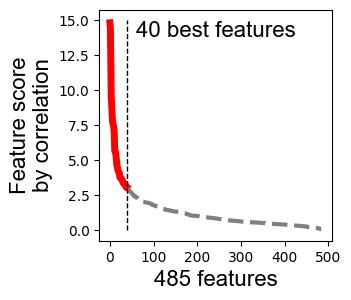

In [7]:
elbow=40
sorted_mean_score=np.flip(np.sort(np.mean(score_pad_corr,axis=0)))
fig = plt.figure(figsize=(3,3))
ax=fig.add_subplot()
ax.plot(np.arange(40),sorted_mean_score[:40],lw=5,color='red')
ax.plot(np.arange(40,485),sorted_mean_score[40:],lw=3,color='grey',ls='--')
ax.set_xticks([0,100,200,300,400,500])
ax.set_xlabel('{} features'.format(len(numeric_feature_cols)),fontsize=16,fontname='Arial')
ax.set_ylabel('Feature score\nby correlation'.format(len(numeric_feature_cols)),fontsize=16,fontname='Arial')
ax.vlines(elbow,ymin=0,ymax=15,color='black',lw=1,ls='--')
ax.text(elbow+20,15,'{} best features'.format(elbow),fontname='Arial',fontsize=16,va='top',ha='left')
#axes[0].set_xticks([])
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20231207_linear_model_feature_selection.svg',
            bbox_inches='tight',transparent=True)

In [9]:
n_best_features=40
n_best_cols = np.array(numeric_feature_cols)[np.flip(np.argsort(np.mean(score_pad_corr,axis=0)))[:n_best_features]]
print(n_best_cols)


['Nterm30_flDPnn_mean' 'Nterm30_flDPnn>0.2_frac' 'flDPnn>0.2_count'
 'flDPnn>0.5_count' 'Nterm15_flDPnn_mean' 'flDPnn>0.2_frac'
 'flDPnn>0.5_frac' 'Cterm30_SV4' 'flDPnn_STD' 'Cterm15_SV4'
 'Nterm15_flDPnn>0.2_frac' 'Nterm30_KF9' 'Nterm30_SVGER3' 'flDPnn_mean'
 'Nterm30_BLOSUM4' 'Nterm30_ProtFP8' 'Nterm30_flDPnn_std'
 'Nterm30_BLOSUM5' 'Nterm30_SVGER8' 'Nterm30_ST7' 'Nterm30_SV4'
 'Cterm30_KF6' 'Full_BLOSUM5' 'Nterm30_VHSE1' 'Nterm30_ProtFP7'
 'Cterm15_KF6' 'Nterm30_E1' 'Nterm30_SVGER11' 'Cterm15_T4' 'Nterm30_KF4'
 'Nterm30_BLOSUM8' 'Cterm30_ProtFP5' 'Nterm30_Z1' 'Nterm30_ProtFP1'
 'Cterm15_SVGER4' 'Nterm30_BLOSUM1' 'Nterm15_SVGER11' 'Cterm30_KF7'
 'Cterm15_ProtFP5' 'Nterm30_pLDDT_std']


In [10]:
Cs = np.array([0.02,0.05,0.08,0.1])
pvals = []
models = []
#X_train,y_train = train_df[n_best_cols].values,train_df['log2(Deg constant)'].values
#X_test,y_test = validation_df[n_best_cols].values,validation_df['log2(Deg constant)'].values

X,y = train_df[n_best_cols].values,train_df['log2(Deg constant)'].values

scores = np.zeros((len(Cs),10))
for k,C in enumerate(Cs):
    for j,rand in enumerate(range(0,50,10)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rand)
        # fit with simple linear regression model
        m=Lasso(alpha=C).fit(X_train,y_train)
        pred = m.predict(X_test)
        r,p = pearsonr(pred,y_test)
        scores[k,j]=p
        #pvals.append(p)
        #models.append(m)
Best_C = Cs[np.argmax(np.median(scores,axis=1))]

### Lasso model training and evaluation

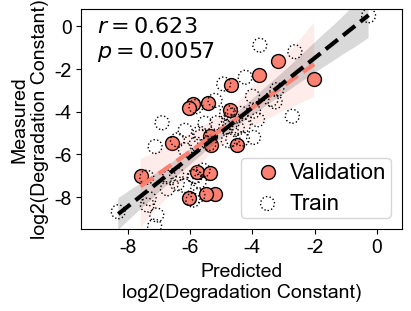

In [11]:
from sklearn.linear_model import LinearRegression as lr, Lasso
from sklearn.svm import SVR
from scipy.stats import pearsonr

pvals = []
models = []

# Now train on the entire training set with optimal hyperparameter alpha=0.08 and test on the validation set.
X_train,y_train = train_df[n_best_cols].values,train_df['log2(Deg constant)'].values
X_test,y_test = validation_df[n_best_cols].values,validation_df['log2(Deg constant)'].values

m=Lasso(alpha=Best_C).fit(train_df[n_best_cols].values,
                  train_df['log2(Deg constant)'].values)
pred = m.predict(X_test)
r,p = pearsonr(pred,y_test)
pvals.append(p)
models.append(m)

# Plot best model

fig=plt.figure(figsize=(4,3),layout='constrained')
ax=fig.add_subplot()

best_model = models[np.argmin(pvals)]


pred_val = best_model.predict(X_test)
pred_train = best_model.predict(X_train)


ax.scatter(pred_val,y_test,color='salmon',ec='black',s=100,label='Validation')
sns.regplot(x=pred_val,y=y_test,scatter=False,color='salmon',line_kws={'lw':3,'ls':'--'})

r,p = pearsonr(y_test,pred_val)
ax.text(0.05,0.78,'$r=$${}$\n$p=$${}$'.format(round(r,3),round(p,4)),transform=ax.transAxes,fontsize=16,fontname='Arial',ha='left')

ax.scatter(pred_train,y_train,fc='None',ec='black',s=100,ls=':',label='Train')
sns.regplot(x=pred_train,y=y_train,scatter=False,color='black',line_kws={'lw':3,'ls':'--'})
ax.legend(loc=4,prop={'family':'Arial','size':16},handletextpad=0,borderpad=0.2)
ax.set_xlim(-9.5,0.8)
ax.set_ylim(-9.5,0.8)
ax.set_xticks([-8,-6,-4,-2,0])
ax.set_xticklabels([-8,-6,-4,-2,0],fontsize=14,fontname='Arial')
ax.set_yticks([-8,-6,-4,-2,0])
ax.set_yticklabels([-8,-6,-4,-2,0],fontsize=14,fontname='Arial')
ax.set_xlabel('Predicted\nlog2(Degradation Constant)',fontsize=14,fontname='Arial')
ax.set_ylabel('Measured\nlog2(Degradation Constant)',fontsize=14,fontname='Arial')

plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20231207_linear_model_training.svg',
            bbox_inches='tight',transparent=True)

In [12]:
best_model

Lasso(alpha=0.08)

### Plot the linear association between the top 40 features and protein degradation potential
### Supplementary Fig. 11

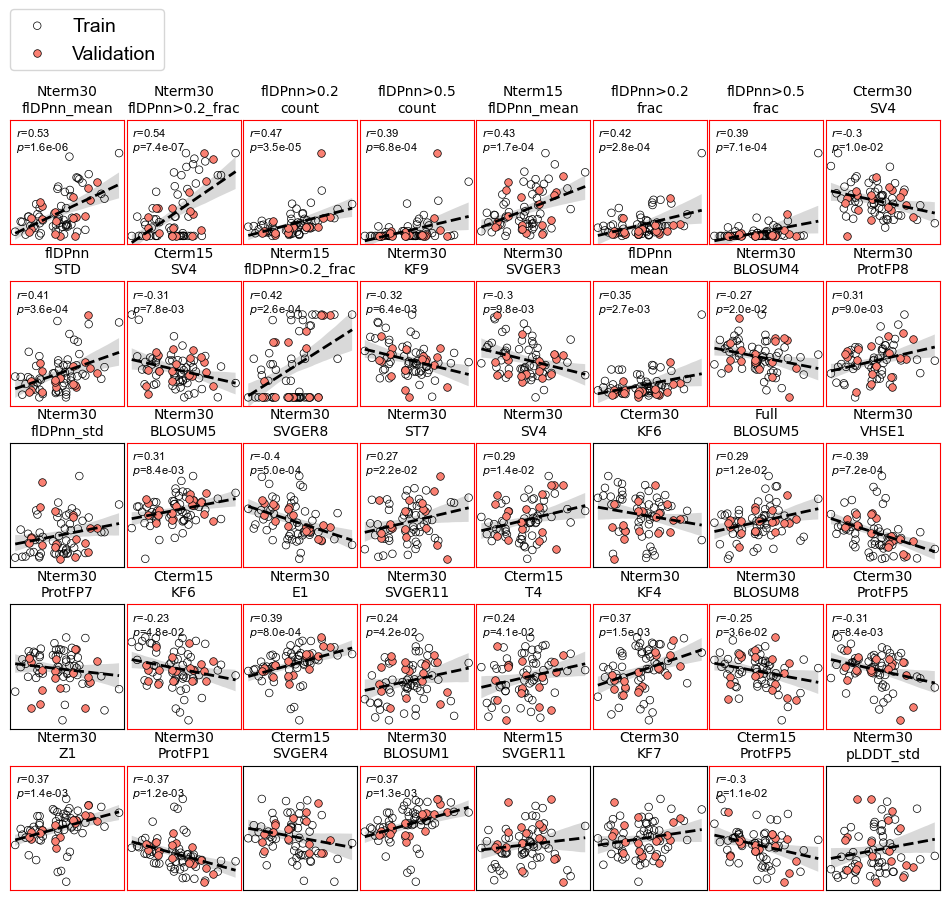

In [13]:
fig = plt.figure(figsize=(12,10))
grids=gs(5,8,hspace=0.3,wspace=0.02)

for i,f in enumerate(n_best_cols):
    if i<40:
        r=int(i/8)
        c=i%8
        ax=fig.add_subplot(grids[r,c])
        ax.set_xticks([])
        ax.set_yticks([])
        v = pooled_stats[f].values
        t = pooled_stats['log2(Deg constant)'].values
        sns.regplot(x=t,y=v,ax=ax,scatter=False,
                    line_kws={'color':'black','ls':'--','lw':2})
        v_train,t_train = train_df[[f,'log2(Deg constant)']].values.T
        v_val,t_val = validation_df[[f,'log2(Deg constant)']].values.T
        r,p = pearsonr(v,t)
        ax.set_ylim(v.min()-(v.max()-v.min())*0.1,v.max()+(v.max()-v.min())*0.4)
        if p<0.05:
            ax.text(0.05,0.95,'$r$={}\n$p$={:0.1e}'.format(round(r,2),p),transform=ax.transAxes,ha='left',
                    va='top',fontname='Arial',fontsize=8)
            for k,sp in ax.spines.items():
                sp.set_color('r')
            
            
        if i==0:
            ax.scatter(t_train,v_train,s=30,ec='black',fc='None',label='Train',lw=0.5)
            ax.scatter(t_val,v_val,s=30,ec='black',fc='salmon',label='Validation',lw=0.5)
            #ax.set_ylim(v.min()-(v.max()-v.min())*0.1,v.max()*1.2)
            ax.legend(loc=(0,1.4),prop={'family':'Arial','size':14})
        else:
            ax.scatter(t_train,v_train,s=30,ec='black',fc='None',lw=0.5)
            ax.scatter(t_val,v_val,s=30,ec='black',fc='salmon',lw=0.5)
        ax.set_title('{}\n{}'.format(f.split('_')[0],
                                     '_'.join(f.split('_')[1:])),fontsize=10)
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20231207_linear_feature_landscape.svg',
            bbox_inches='tight')

### Zoom-in view

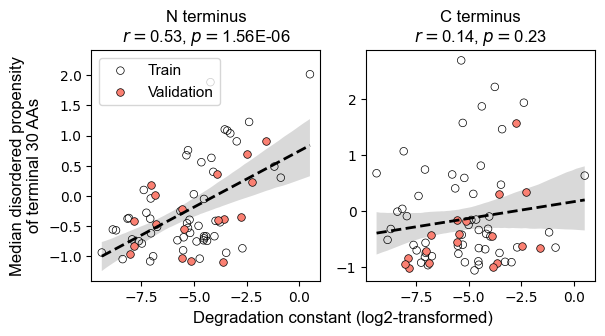

In [53]:
fig,axes=plt.subplots(figsize=(6.5,3),ncols=2)
for i,f in enumerate(['Nterm30_flDPnn_mean','Cterm30_flDPnn_mean']):
    v = pooled_stats[f].values
    t = pooled_stats['log2(Deg constant)'].values
    sns.regplot(x=t,y=v,scatter=False,
                line_kws={'color':'black','ls':'--','lw':2},ax=axes[i])
    v_train,t_train = train_df[[f,'log2(Deg constant)']].values.T
    v_val,t_val = validation_df[[f,'log2(Deg constant)']].values.T
    if i==0:
        axes[i].scatter(t_train,v_train,s=30,ec='black',fc='None',label='Train',lw=0.5)
        axes[i].scatter(t_val,v_val,s=30,ec='black',fc='salmon',label='Validation',lw=0.5)
        axes[i].set_ylim(v.min()-(v.max()-v.min())*0.1,v.max()*1.2)
        axes[i].legend(loc=0,prop={'family':'Arial','size':11})
        #axes[i].set_ylim(-0.02,0.7)
    else:
        axes[i].scatter(t_train,v_train,s=30,ec='black',fc='None',lw=0.5)
        axes[i].scatter(t_val,v_val,s=30,ec='black',fc='salmon',lw=0.5)
        #axes[i].set_ylim(-0.02,0.7)
    r,p = pearsonr(v,t)
    if p<0.05:
        axes[i].set_title('N terminus\n$r=${}, $p=${:.2E}'.format(round(r,2),p),fontname='Arial',fontsize=12)
    else:
        axes[i].set_title('C terminus\n$r=${}, $p=${}'.format(round(r,2),round(p,2)),fontname='Arial',fontsize=12)
axes[0].set_ylabel('Median disordered propensity\nof terminal 30 AAs',fontname='Arial',fontsize=12)
axes[0].text(1.1,-0.13,'Degradation constant (log2-transformed)',fontname='Arial',fontsize=12,transform=axes[0].transAxes,ha='center',va='top')
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20231207_term_flDPnn_median.svg',
            bbox_inches='tight')

### Apply to the 348 proteins

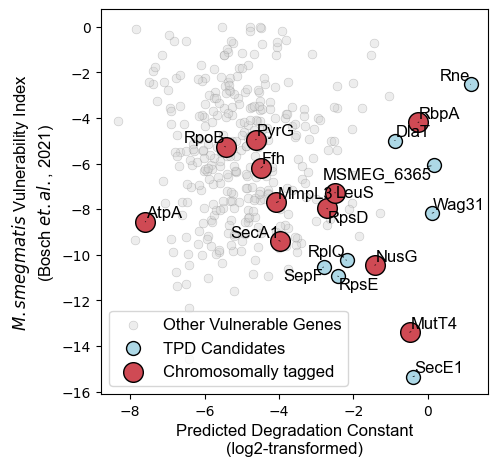

In [14]:
ortho_normalized['Pred'] = best_model.predict(ortho_normalized[n_best_cols].values)
future_cand = ortho_normalized[(ortho_normalized['Pred']>-3)&(ortho_normalized['Msm_VI']<-10)]
future_cand2 = ortho_normalized[(ortho_normalized['Pred']>-1)]
mtb_gff=pd.read_excel('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Important_references/mtb_gff.xls').set_index('Locus')
rv_gene_names = mtb_gff.loc[future_cand['rv'].values]['Name'].values

fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot()
ortho_normalized['gene'] = ortho_normalized.index
ortho_normalized['Pred'] = best_model.predict(ortho_normalized[n_best_cols].values)
ax.scatter(data=ortho_normalized,x='Pred',y='Msm_VI',fc='lightgrey',s=40,ec='grey',
           alpha=0.4,lw=0.4,label='Other Vulnerable Genes')
ax.set_xlabel('Predicted Degradation Constant\n(log2-transformed)',fontsize=12,fontname='Arial')
ax.set_ylabel('$M.smegmatis$ Vulnerability Index\n(Bosch $et. al.$, 2021)',fontsize=12,fontname='Arial')

names = ['RpoB','RbpA','SecA1','Ffh','PyrG','MutT4',
         'NusG','AtpA','RpsD','MmpL3','LeuS']
locus_tags = ['MSMEG_1367','MSMEG_3858','MSMEG_1881','MSMEG_2430','MSMEG_3746','MSMEG_6927',
              'MSMEG_1345','MSMEG_4942','MSMEG_1523','MSMEG_0250','MSMEG_6917']


tested = ['MSMEG_0250','MSMEG_3858','MSMEG_1367','']
texts = []
for i,(locus,vi,pred) in enumerate(future_cand[['gene','Msm_VI','Pred']].values):
    if rv_gene_names[i].startswith('Rv'):
        name = locus
    else:
        name = rv_gene_names[i]
    if name == 'MSMEG_4219':
        name='SepF'
    if locus not in locus_tags:
        if i==0:
            ax.scatter(pred,vi,color='lightblue',s=100,ec='black',label='TPD Candidates')
            texts.append(ax.text(pred,vi,name[0].upper()+name[1:],
                                 fontname='Arial',
                                 fontsize=12))
        else:
            ax.scatter(pred,vi,color='lightblue',s=100,ec='black')
            texts.append(ax.text(pred,vi,name[0].upper()+name[1:],
                                 fontname='Arial',
                                 fontsize=12))


rv_gene_names2 = mtb_gff.loc[future_cand2['rv'].values]['Name'].values
for i,(locus,vi,pred) in enumerate(future_cand2[['gene','Msm_VI','Pred']].values):
    if rv_gene_names2[i].startswith('Rv'):
        name = locus
    else:
        name = rv_gene_names2[i]
    if locus not in future_cand['gene'].values and locus not in pooled_stats['Locus'].values and locus not in locus_tags:
        ax.scatter(pred,vi,color='lightblue',s=100,ec='black')
        texts.append(ax.text(pred,vi,name[0].upper()+name[1:],
                             fontname='Arial',
                             fontsize=12))

pred,vi =ortho_normalized.loc[locus_tags][['Pred','Msm_VI']].values.T

for i,(name,locus) in enumerate(zip(names,locus_tags)):
    if i==0:
        ax.scatter(pred[i],vi[i],color=np.array([207,74,84])/255,s=200,ec='black',label='Chromosomally tagged')
    else:
        ax.scatter(pred[i],vi[i],color=np.array([207,74,84])/255,s=200,ec='black')
    texts.append(ax.text(pred[i],vi[i],name,
                         fontname='Arial',
                         fontsize=12))

ax.legend(prop={'size':12,'family':'Arial'},title='')
adt(texts,force_text=(0.2,0.3),arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20231207_TPD_prediction.svg',
            bbox_inches='tight',transparent=True)

In [15]:
ortho_normalized.to_excel('./Important_References/20231213_ortho_normalized_pred.xlsx')